## General information

이 내용은 안드레이 룩야넨코의 노트북을 한글화한 것 입니다.
이 커널에서는 IEEE Fraud Detection competition을 다룹니다.

IEEE-CIS는 다양한 분야의 AI 및 머신러닝 부분에서 일하고 있는데요	
이는 deep neural networks, fuzzy systems, evolutionary computation 및 swarm intelligence를 포함합니다
이제 세계 굴지의 지불 시스템 회사인 Vesta와 협력하여, 카드 사기 방지를 할 수 있는 최적의 솔루션을 찾아서 수 많은 데이터 사이언티스트에게 이에 도전하라고 했습니다

이 챌린지는 binary classification problem으로 이러한 과제가 경험할 수 밖에 없는 data의 심한 imbalance를 보여 줍니다.
우리는 여기서 데이터를 탐구하고 소중한 인사이트를 파악하여 많은 feature engineering을 통하여 성능이 높은 모델링을 하려고 합니다

![](https://cis.ieee.org/images/files/slideshow/abstract01.jpg)


Importing libraries

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
pd.options.display.precision = 15
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from numba import jit
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb
%load_ext autoreload
%autoreload 2

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
seed = 42
seed_everything(seed)

## Data overview

In [3]:
folder_path = '../input/'
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')
# let's combine the data and work with the whole dataset
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


우리는 열이 많은 꽤 큰 데이터셋 두 개를 볼 수 있습니다. Train과 test data는 비슷한 길이의 행을 가지고 있습니다.

In [6]:
train_identity.shape

(144233, 41)

In [7]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [8]:
train_transaction.shape

(590540, 394)

In [9]:
test_identity.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [10]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.949999999999999,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,47.950000762939453,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,47.950000762939453,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.000000000000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000000000000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0

데이터는 두 개로 나누어져 있는 것 같습니다: identity와 transaction.

아무래도 identity는 어떤 카드인가에 초점이 맞추어 지겠고 id 30또는 31을 보면 안드로이드나 크롬 같은 단어도 나옵니다?

Identity 40개 가량의 열이 있고 열의 내용을 눈치채게 할 이름은 없습니다.

하지만 사용자의 버전을 볼 수 있죠: OS, browser version, resolution, type 및 기타 등 등 

Transaction data는 거의 400 columns가 있습니다!

주목 할만한 열들은 다음과 같습니다:

card information

transaction date & amount

e-mail

In [11]:
# 어떤 이유에선지 테스트 컬럼에서 언더바 대신 하이픈으로 쓴 것이 있어서 좀 바꿉니다.
test_identity.columns = [col.replace('-', '_') for col in test_identity.columns]

# merge method를 사용하여 트레인과 테스트의 트랜잭션(거래)와 아이덴티티(신분)을 파일을 합합니다. 
# 여기서 on은 그 것을 인덱스로 합치라는 것이고 left나 right는 왼쪽 것 기준으로 또는 오른쪽 것 기준으로 파일을 정열하는데...여기서 말하는 기준은 데이터 값이 있는 것입니다.
# 다시 말해 left로 되어 있는데 왼쪽의 transaction의 해당 행이 빈 값이면 identity에 값이 있어도 그 행은 보이지 않게되고, 반대로 right라면 그 행은 보이게 됩니다.

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

그리고 기존 데이터는 무거우니 지웁니다.

In [12]:
del train_transaction, train_identity, test_transaction, test_identity

트레인 데이터에는 C1부터 C15까지 빈 값이 없으나 테스트 데이터에서는 빈값이 있어서 이들의 빈 값을 0으로 채웁니다.

아래에서 f는 f-string이라 불리는 것으로 이를 통해 다양한 표현식을 사용할 수 있다.

예를 들어 python2에서 나오는 %나 python3에서 나오는 str.format과 비교하였을 때 훨씬 간단하게 표현할 수 있다 

In [13]:
test[[f'C{i}' for i in range(1,15)]] = test[[f'C{i}' for i in range(1,15)]].fillna(0)

이어서 얼마나 많은 램을 쓰는지 한 번 보기로 하자

In [14]:
end_mem = train.memory_usage().sum() / 1024 ** 2 + test.memory_usage().sum() / 1024 ** 2
print(f'Mem. usage {end_mem:5.2f} Mb')

Mem. usage 3637.61 Mb


이는 상당히 많이 쓴 것으로 RAM사용량을 줄이는 메소드가 있으므로 사용해 보도록 합니다

정보는 그대로 주고 데이터 타입을 줄이므로 이를 달성합니다.

아시다시피 integer가 float보다 메모리를 덜 사용하고 integer8이 integer16보다 메모리를 덜 사용합니다.

일단 낮출 수 잇는 만큼 낮추어 보겠습니다.

In [15]:
def reduce_mem_usage(memory_df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = memory_df.memory_usage().sum() / 1024 ** 2
    for col in memory_df.columns:
        col_type = memory_df[col].dtypes
        if col_type in numerics:
            c_min = memory_df[col].min()
            c_max = memory_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    memory_df[col] = memory_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    memory_df[col] = memory_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    memory_df[col] = memory_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    memory_df[col] = memory_df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    memory_df[col] = memory_df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    memory_df[col] = memory_df[col].astype(np.float32)
                else:
                    memory_df[col] = memory_df[col].astype(np.float64)
    end_mem = memory_df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
            start_mem - end_mem) / start_mem))
    return memory_df
#train = reduce_mem_usage(train)
#test = reduce_mem_usage(test)

메모리 사용도가 2/3가 줄어 1/3 수준으로 줄어들었습니다.

## Data Exploration

이제 identity information을 파악해 봅니다.

id_01 - id_11는 continuous variables입니다.

id_12 - id_38는 categorical variable이고 마지막 두 개의 열은 확실히 범주 항목입니다.

In [17]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

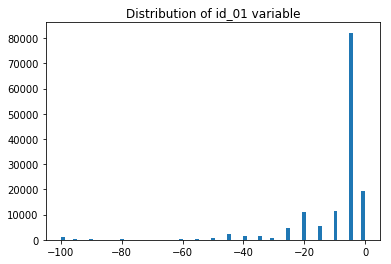

In [18]:
plt.hist(train['id_01'], bins=77);
plt.title('Distribution of id_01 variable');

`id_01` 은 아주 흥미로운 분포를 가지고 있습니다. 77개의 유니크한  양수가 아닌 수로 0에서 비대칭이 일어나는 분포입니다.

In [19]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689233582822
0.0    0.108211128797372
1.0    0.001461374335354
3.0    0.001131168083449
2.0    0.000712906831036
Name: id_03, dtype: float64

`id_03` 은 88%가 빈 값이며 98%가 빈값이거나 0입니다.

In [ ]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

`id_11` 의 값 중 22%는 100이며 76%는 빈 값입니다. 좀 이상합니다.

In [ ]:
plt.hist(train['id_07']);
plt.title('Distribution of id_07 variable');

일부 항목은 normalized 된 것 같습니다. 모든 항목을 normalize하려면 이미 normalized 된 것은 분리하여야 할 것입니다. 

이제 transaction data를 살펴 보겠습니다.

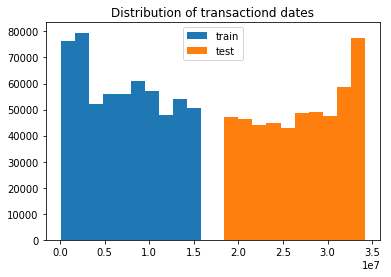

In [20]:
plt.hist(train['TransactionDT'], label='train');
plt.hist(test['TransactionDT'], label='test');
plt.legend();
plt.title('Distribution of transactiond dates');

여기서 중요점이 발견 됩니다.

트레인 및 테스트 트랜잭션 날짜가 겹치지 않는 것 같으므로 유효성 검사를 위해 시간 기반 분할을 사용하는 것이 현명할 것입니다.

대회 설명에서도 다음과 같은 내용이 있었습니다. "TransactionDT" 항목은 주어진 참조 날짜 / 시간 (실제 타임 스탬프 아님)의 타임 델타입니다.

시작일이 2017-11-30이라는 것을 깨달았습니다. 이 정보는 나중에 사용할 것입니다.

* 참조 사항

우리가 여기서 사기를 일으키는 카드를 찾는 것이 아니라 그런 사용자를 찾는 것이란 것을 명심하세요.

위의 TransactionDT를 설명 드리면 거래를 하려는데 카드가 정지되거나 카드를 누가 불법으로 썼는데 카드 주인이 모르고 넘어 간다거나 등 등에서 모두 날짜가 중요하겠죠. 

이에 대한 reference 포인트가 될 항목입니다.

In [21]:
start_date = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [22]:
print (start_date)

2017-11-30 00:00:00


### Filling missing values in `card` columns

Сard columns are important but missing values.

In [23]:
for col in train.columns:
    if 'card' in col:
        print(f"{col} has {train[col].isnull().sum()} missing values.")

card1 has 0 missing values.
card2 has 8933 missing values.
card3 has 1565 missing values.
card4 has 1577 missing values.
card5 has 4259 missing values.
card6 has 1571 missing values.


'card1'의 각 값에 대한 'card2'의 가장 일반적인 값을 살펴 보겠습니다.

In [24]:
group_with_mode = train.groupby(['card1']).agg({'card2': ['nunique', pd.Series.mode]})
group_with_mode.head(10)

card2     
      nunique mode
card1             
1000        1  555
1001        1  555
1004        1  583
1005        1  543
1006        1  399
1007        1  555
1008        1  555
1009        1  399
1010        1  555
1011        1  543

'card1'의 유니크한 값이 얼마나 있는지, 1개를 초과하는 유니크한 값을 가진 'card1'의 유니크한 값이 얼마나 있는지 보겠습니다

In [25]:
non_one = group_with_mode[group_with_mode['card2']['nunique'] > 1].shape[0]
card1_nunique = train['card1'].nunique()
print(f'Number of unique values of card1: {card1_nunique}')
print(f'Number of unique values of card1 which have more than one unique value: {non_one}')

Number of unique values of card1: 13553
Number of unique values of card1 which have more than one unique value: 248


대부분의 경우 card1의 각 값에 대해 card2 열에는 고유 한 값이 하나만 있습니다. 이것을 참조하여 누락 된 값을 채워 봅시다

In [26]:
for card in ['card2','card3','card4','card5','card6']:
    group_with_mode = train.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(train['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(train[card])
    train[card] = merged['mode']
    
    group_with_mode = test.groupby(['card1']).agg({card: ['nunique', pd.Series.mode]})
    to_merge = group_with_mode[group_with_mode[card]['nunique'] == 1][card]['mode']
    merged = pd.merge(test['card1'], to_merge, on='card1', how='left')
    merged['mode'] = merged['mode'].fillna(test[card])
    test[card] = merged['mode']

## Target and Users

라벨링 로직에 대한 정보는 https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#588953 에서 볼 수 있습니다.
```
라벨링의 논리는 카드에 보고된 지불 거절을 사기 거래 (isFraud = 1)로 정의하고 사용자 계정, 이메일 주소 또는 이러한 속성에 직접 연결된 청구 주소를 사기로 사후에 거래하는 것입니다. 

120 일이 지난 후에도 위에 나온 것들에서 보고된 것이 없는 경우 합법적인 거래로 정의합니다 (isFraud = 0).
```

결과적으로 사기의 경우 단일 거래가 사기로 간주될 뿐만 아니라 사용자의 다른 거래도 사기로 간주된다는 것을 알 수 있기 때문에 이것은 매우 중요합니다. (다른 카드 모두 정지될 테니까요)

하지만 우리에게는 데이터에 사용자 ID가 있는 열이 없습니다. 익명 처리되었습니다. 

결과적으로 다른 열을 기반으로 사용자 ID 열을 만들어야 겠지요. 

예를 들어 주소와 카드 정보의 조합을 ID로 사용할 수 있습니다.

우리는 'D1'이 사용자의 첫 거래 이후 일수를 의미한다는 것을 알고 있습니다.

더 나아가기 전에 캐글의 컬럼 정보 부분을 다시 보겠습니다.

* TransactionDT: 주어진 포인트로부터 타임델타 (실 타임 스템프는 아님)
* TransactionAMT: 미국 달러로 결제한 거래 액수
* ProductCD: 상품 코드, 거래한 상품
* card1 — card6: 지불 수단 카드 정보, 카드 타입, 카드 분류, 은행, 국가 등
* addr: 주소
* dist: 거리
* P_ and (R__) emaildomain: 구매자의 이메일 정보
* C1-C14: 카운팅 얼마나 많은 주소가 연결되었느냐 등인데 실제 내용은 마스킹 되어 있어서 파악이 안 됨
* D1-D15: 타임델타, 예를 들어 그 전 거래부터 얼마나 되었는지 등
* M1-M9: 매치...카드와 이름 주소의 매치 등
* Vxxx: Vesta 제작 항목 랭킹, 카운팅, 기타 관련
* identity table의 항목은 네트워크 연결 정보 예를 들어 IP, ISP, Proxy, 등 또는 디지털 시그내쳐 UA/browser/os/version 등으로 거래 관련 정보를 나타낸다

DaysFromStart라는 항목을 만듭니다. 

TransactionDT에서 60초 60분 24시간을 나누어서 버림(floor)로 해서 1을 뺀 날짜를 구하고 

D1-DaysFromStart 항목을 만들어 D1-DaysFromStart 날짜를 봅니다

In [27]:
for df in [train,test]:
    df['DaysFromStart'] = np.floor(df['TransactionDT']/(60*60*24)) - 1
    df['D1-DaysFromStart'] = df['D1'] - df['DaysFromStart']

이어서 연속으로 정보를 합쳐서 uid를 생성합니다

In [28]:
for df in [train,test]:
    df['uid'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card3'].astype(str) + '_' + df['card4'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card5'].astype(str) + '_' + df['card6'].astype(str)
    df['uid'] = df['uid'] + '_' + df['addr1'].astype(str) + '_' + df['D1-DaysFromStart'].astype(str)

uid의 크기와 유니크한 값을 보겠습니다

In [29]:
len(set(train['uid']).intersection(set(test['uid']))), train.uid.nunique(), test.uid.nunique()

(26891, 231339, 205162)

In [30]:
train['uid'].value_counts(dropna=False, normalize=True).head(20)

S_15775_481.0_150.0_mastercard_102.0_credit_330.0_-128.0    0.002394418667660
W_9500_321.0_150.0_visa_226.0_debit_126.0_86.0              0.000755240965896
W_8900_385.0_150.0_visa_226.0_debit_231.0_61.0              0.000392860771497
W_8528_215.0_150.0_visa_226.0_debit_387.0_160.0             0.000364073559793
C_12616_490.0_150.0_visa_nan_credit_nan_492.0               0.000357300098215
W_12741_106.0_150.0_visa_226.0_debit_143.0_203.0            0.000331899617299
W_7207_111.0_150.0_visa_226.0_debit_204.0_466.0             0.000323432790327
C_15885_545.0_185.0_visa_138.0_debit_nan_-21.0              0.000294645578623
W_13597_198.0_150.0_visa_226.0_debit_191.0_49.0             0.000250618078369
W_4121_361.0_150.0_visa_226.0_credit_476.0_9.0              0.000240457886003
C_15885_545.0_185.0_visa_138.0_debit_nan_-26.0              0.000231991059031
C_15885_545.0_185.0_visa_138.0_debit_nan_-19.0              0.000226910962848
C_15885_545.0_185.0_visa_138.0_debit_nan_-28.0              0.00

트레인 데이터와 테스트 데이터간에 일부 uid 만 겹치는 것을 볼 수 있습니다. 즉, 이 항목을 직접 적용하여 사용할 수 없으며 이를 기반으로 다양한 항목을 만들어 사용해야 할 것 같습니다.

### processing some device information and ids

DeviceInfo의 밸류 카운트를 보겠습니다

In [31]:
train['DeviceInfo'].value_counts(dropna=False, normalize=True).head(20)

NaN                            0.799055102109933
Windows                        0.080810783350831
iOS Device                     0.033498154231720
MacOS                          0.021290683103600
Trident/7.0                    0.012598638534223
rv:11.0                        0.003219087614726
rv:57.0                        0.001629017509398
SM-J700M Build/MMB29K          0.000929657601517
SM-G610M Build/MMB29K          0.000780641446811
SM-G531H Build/LMY48B          0.000694279811698
rv:59.0                        0.000612998272767
SM-G935F Build/NRD90M          0.000565584041725
SM-G955U Build/NRD90M          0.000555423849358
SM-G532M Build/MMB29T          0.000535103464626
ALE-L23 Build/HuaweiALE-L23    0.000528330003048
SM-G950U Build/NRD90M          0.000491075964372
SM-G930V Build/NRD90M          0.000463982118061
rv:58.0                        0.000455515291090
rv:52.0                        0.000433501540963
SAMSUNG                        0.000397940867680
Name: DeviceInfo, dt

보시면, 거의 80%가 빈 값이고. 윈도우가 8%가량, iOS가 3.34% 등 나오고 삼성도 좀 보입니다.

유니크한 값이 몇개 인지 보겠습니다.

In [32]:
train['DeviceInfo'].nunique()

1786

아주 많은 디바이스가 있습니다. 그리고 80% 가량은 빈값이니 어느 장비인 줄 알 수가 없습니다.

이를 좀 고쳐서 항목을 만들어 보려 하겠습니다

In [33]:
for df in [train, test]:
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

join은 데이터를 합쳐 주는데 dtype이 같아야만 합니다

모델명 숫자 등을 지우고 종류를 정리해 보았습니다

아래에서 얼마나 줄어들었는지 봅니다

In [34]:
df['DeviceInfo_device'].value_counts(dropna=False, normalize=True).head(20)

unknowndevice          0.772924721378513
windows                0.088787841110262
iosdevice              0.036945594060285
macos                  0.022003548513788
trident                0.009650852294594
rv                     0.005549733466748
smgu                   0.001569003593906
smgmbuildmmbt          0.001310463379061
motog                  0.001036134448806
smgf                   0.001018372143969
smjm                   0.000972979587165
smgfbuildrnw           0.000943375745770
smgm                   0.000937454977491
motogplus              0.000799303717650
samsungsmgubuildrnw    0.000785488591666
smgubuildrnw           0.000742069624288
smgmbuildmmbk          0.000724307319451
motogplay              0.000722333730025
motoebuildnma          0.000712465782893
smaf                   0.000645363742399
Name: DeviceInfo_device, dtype: float64

In [35]:
df['DeviceInfo_version'].value_counts(dropna=False, normalize=True).head(20)

         0.923432624617370
70       0.009688350493693
3        0.002105819917859
53229    0.001722943569158
5        0.001636105634400
110      0.001482165659149
95016    0.001456508996607
610      0.001328225683898
4        0.001322304915619
33       0.001306516200209
950      0.001241387749141
6        0.001170338529794
0303     0.001091394952742
630      0.000935481388065
2        0.000894036010113
61029    0.000751937571419
70029    0.000696677067483
03       0.000696677067483
700      0.000672993994367
620      0.000661152457810
Name: DeviceInfo_version, dtype: float64

'id_30' 의 밸류 카운트를 비율로 봅니다

In [36]:
df['id_30'].value_counts(dropna=False, normalize=True).head(20)

NaN                 0.860548144727260
Windows 10          0.041474981793638
Windows 7           0.020462175171850
iOS 12.1.0          0.012530319267561
iOS 11.4.1          0.006982559390240
Mac OS X 10_13_6    0.006422059993171
Android 8.0.0       0.004845162041560
iOS 12.0.1          0.003337339719869
iOS 11.4.0          0.003167611029207
Mac OS X 10_11_6    0.002869599025836
Windows 8.1         0.002751183660258
Linux               0.002668292904354
Mac OS X 10_12_6    0.002615005989844
iOS 12.0.0          0.002476854730003
iOS 12.1.2          0.002384096026967
Mac OS X 10_14_1    0.002097925560154
Mac OS X 10_10_5    0.001823596629899
Android             0.001517690268823
Android 7.0         0.001385459777261
iOS 11.3.0          0.001274938769388
Name: id_30, dtype: float64

유니크한 값이 몇개나 있는지 보겠습니다.

In [37]:
train['id_30'].nunique()

75

'id_31' 의 밸류 카운트를 비율로 봅니다

In [38]:
df['id_31'].value_counts(dropna=False, normalize=True).head(20)

NaN                        0.730358344632133
chrome 70.0                0.031684004649777
mobile safari 12.0         0.025850074305642
mobile safari 11.0         0.020193767009874
chrome 71.0                0.018727390066135
chrome 69.0                0.016366977112283
chrome 70.0 for android    0.015046645786091
chrome 68.0                0.012727678210191
chrome 67.0                0.012082314467792
chrome 69.0 for android    0.011884955525162
ie 11.0 for desktop        0.010209378102236
chrome 71.0 for android    0.009925181224849
edge 17.0                  0.009613354095494
chrome 67.0 for android    0.007175971154017
safari 12.0                0.007006242463355
chrome 68.0 for android    0.006947034780566
safari 11.0                0.005717488567983
firefox 63.0               0.003747846320539
samsung browser 7.4        0.002701843924601
firefox 61.0               0.002607111632139
Name: id_31, dtype: float64

이들을 위에 DeviceInfo에 했던 것 처럼 해봅니다.

In [39]:
for df in [train, test]:
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

빈 값에는 unknown device라 입력을 하고 합치고 줄여 봅니다

In [40]:
df['id_30_device'].value_counts(dropna=False, normalize=True).head(20)

unknowndevice    0.860548144727260
windows          0.064873858031818
ios              0.036945594060285
macosx           0.023550842624006
android          0.010815270056109
linux            0.002668292904354
mac              0.000238804320582
windowsvista     0.000197358942630
windowsxp        0.000132230491562
func             0.000021709483689
other            0.000007894357705
Name: id_30_device, dtype: float64

### process some D-columns

우리는 Card 열들은 카드 종류나 카드사 같은 정보라는 것을 위에서 보았으며

id는 사용된 OS나 디바이스 등임을 알았습니다.

이제 D항목들은 어떤 것인지 보겠습니다

일단 D1 에서 D15까지 어떤 값들이 있나 봅니다

In [41]:
train.D1.value_counts()

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
7.0        3455
6.0        3164
5.0        3076
14.0       2979
8.0        2637
28.0       2634
9.0        2387
13.0       2369
42.0       2294
15.0       2222
11.0       2119
10.0       2115
12.0       2071
29.0       2039
21.0       2023
35.0       1964
16.0       1853
30.0       1812
27.0       1791
22.0       1715
20.0       1709
18.0       1707
17.0       1656
43.0       1623
26.0       1607
32.0       1584
19.0       1568
31.0       1549
23.0       1535
56.0       1499
25.0       1440
24.0       1434
36.0       1373
34.0       1368
33.0       1343
63.0       1337
41.0       1295
37.0       1221
55.0       1220
62.0       1206
49.0       1201
57.0       1200
91.0       1192
40.0       1162
70.0       1157
39.0       1130
38.0       1118
61.0       1105
48.0       1095
59.0       1094
60.0       1083
58.0       1079
84.0       1071
44.0       1068
50.0       1007
45.0       1002
54.0        994
64.0    

In [ ]:
train.D2.value_counts()

In [ ]:
train.D3.value_counts()

In [ ]:
train.D4.value_counts()

In [ ]:
train.D5.value_counts()

In [ ]:
train.D6.value_counts()

In [ ]:
train.D7.value_counts()

In [ ]:
train.D8.value_counts()

In [ ]:
train.D9.value_counts()

In [ ]:
train.D10.value_counts()

In [ ]:
train.D11.value_counts()

In [ ]:
train.D12.value_counts()

In [ ]:
train.D13.value_counts()

In [ ]:
train.D14.value_counts()

In [ ]:
train.D15.value_counts()

D8과 D9의 분포부터 보겠습니다

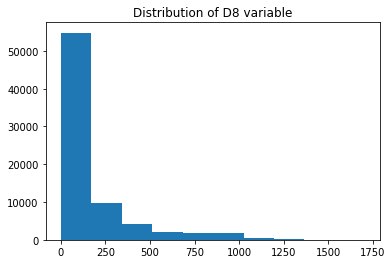

In [42]:
plt.hist(train['D8']);
plt.title('Distribution of D8 variable');

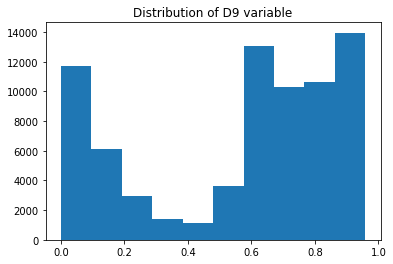

In [43]:
plt.hist(train['D9']);
plt.title('Distribution of D9 variable');

In [44]:
for df in [train, test]:
    # 클립 메소드를 사용하면 음수를 0으로 만들 수 있습니다
    for col in ['D'+str(i) for i in range(1,16)]:
        df[col] = df[col].clip(0)
    
    # D9을 빈 값이 아닌 것을 따로 떼어내어 D9_not_na 항목을 새로 만듭니다.
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    # D8을 1보다 크거나 같은 것만 떼어내어 D8_not_same_day 항목을 만듭니다
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    # D8에서 소수점 이하를 뽑아서 D8_D9_decimal_dist로 정의한 후 여기서 D9을 뺍니다
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

In [45]:
df.D9_not_na.value_counts()

0    432353
1     74338
Name: D9_not_na, dtype: int64

In [ ]:
df.D8_not_same_day.value_counts()

In [ ]:
df.D8_D9_decimal_dist.value_counts()

In [ ]:
df.D8.value_counts()

## Process `TransactionAmt`

이제는 거래 액수에 대해 보겠습니다 분포를 보겠습니다

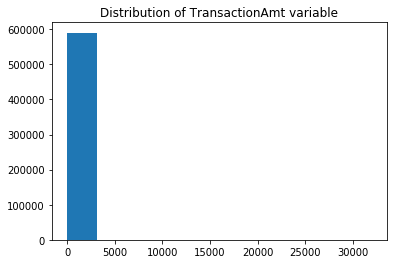

In [46]:
plt.hist(train['TransactionAmt']);
plt.title('Distribution of TransactionAmt variable');

상위 1%(퍼센타일 99) 를 봅니다 

In [47]:
np.percentile(train['TransactionAmt'], 99)

1104.0

In [48]:
# 클립하여 0부터 5000사이의 값으로 봅니다
train['TransactionAmt'] = train['TransactionAmt'].clip(0,5000)
test['TransactionAmt']  = test['TransactionAmt'].clip(0,5000)

# 거래 액수가 일반적인지 아닌지를 봅니다
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

In [49]:
train.TransactionAmt_check.value_counts()

1    573620
0     16920
Name: TransactionAmt_check, dtype: int64

In [50]:
test.TransactionAmt_check.value_counts()

1    504328
0      2363
Name: TransactionAmt_check, dtype: int64

트레인 거래액수에서 테스트 거래 액수에 없는 것이 16,920건 테스트 거래 액수에서 트레인 거래 액수에 없는 것이 2363건인 것을 볼 수 있습니다.

다른 유용한 항목들을 만들어 봅니다.

In [51]:
for df in [train, test]:
    df['ProductCD_card1'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str)
    df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
    df['TransactionAmt_dist2'] = df['TransactionAmt'].astype(str) + '_' + df['dist2'].astype(str)
    df['card3_card5'] = df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['ProductCD_TransactionAmt'] = df['ProductCD'].astype(str) + '_' + df['TransactionAmt'].astype(str)
    df['cents'] = np.round(df['TransactionAmt'] - np.floor(df['TransactionAmt']), 3)
    df['ProductCD_cents'] = df['ProductCD'].astype(str) + '_' + df['cents'].astype(str)
    df['TransactionAmt'] = np.log1p(df['TransactionAmt'])

In [52]:
df.ProductCD_card1.value_counts()

W_7919     13037
C_15885    12326
W_9500     11279
W_17188     8401
W_15066     5463
           ...  
R_13397        1
R_17905        1
C_15776        1
C_3850         1
W_10699        1
Name: ProductCD_card1, Length: 20656, dtype: int64

In [53]:
df.card1_addr1.value_counts()

15885_nan      11533
17188_299.0     5530
12695_325.0     4533
3154_nan        4391
9633_nan        4388
               ...  
11198_476.0        1
9352_123.0         1
18211_315.0        1
13786_184.0        1
4407_330.0         1
Name: card1_addr1, Length: 37621, dtype: int64

In [54]:
df.TransactionAmt_dist2.value_counts()

59.0_nan           27373
117.0_nan          25804
107.9375_nan       20256
57.9375_nan        20066
100.0_nan          14639
                   ...  
91.4375_7.0            1
29.390625_230.0        1
4.1796875_8.0          1
10.953125_239.0        1
25.0_607.0             1
Name: TransactionAmt_dist2, Length: 23013, dtype: int64

In [55]:
df.ProductCD_TransactionAmt.value_counts()

W_59.0           27365
W_117.0          25802
W_107.9375       20243
W_57.9375        20063
W_49.0           14227
W_226.0          11090
R_100.0          10227
W_39.0            9919
W_29.0            9007
H_50.0            8658
W_47.9375         8230
W_35.9375         7558
W_171.0           7272
W_77.0            6653
W_34.0            6350
W_30.953125       6290
W_25.953125       6288
W_335.0           5451
H_100.0           5328
W_210.0           5250
R_150.0           5127
R_200.0           4933
W_67.9375         4713
W_97.0            4526
H_25.0            4090
W_58.9375         3960
W_160.0           3959
W_92.0            3742
W_108.9375        3591
R_50.0            3085
R_250.0           2969
W_82.9375         2900
W_280.0           2740
W_554.0           2663
W_445.0           2371
W_312.0           2362
W_141.0           2228
W_87.0            2180
W_87.9375         2119
H_75.0            2094
H_150.0           1954
W_108.5           1843
W_44.0            1829
S_50.0     

In [56]:
df.TransactionAmt.value_counts()

4.094344615936279    27373
4.770684719085693    25805
4.690774440765381    20256
4.076477527618408    20066
4.615120410919189    17568
3.931825637817383    14470
3.912023067474365    14235
5.424950122833252    11090
3.688879489898682     9926
3.401197433471680     9021
3.890543937683105     8233
5.017279624938965     7992
3.609227180480957     7559
5.147494316101074     7273
3.258096456527710     6779
4.356709003448486     6660
3.555348157882690     6388
5.303304672241211     6343
3.294099330902100     6294
3.464269876480103     6290
5.817111015319824     5452
5.351858139038086     5252
4.233200073242188     4722
4.584967613220215     4550
4.330733299255371     4186
5.081404209136963     3980
4.093302249908447     3961
4.532599449157715     3763
5.525453090667725     3647
4.699912071228027     3599
3.433987140655518     2941
4.430072307586670     2904
2.772588729858398     2783
5.638354778289795     2745
6.318968296051025     2663
6.100318908691406     2371
5.746203422546387     2362
3

In [57]:
test['ProductCD_card1']

0         W_10409
1          W_4272
2          W_4476
3         W_10989
4         W_18018
           ...   
506686    C_13832
506687     C_3154
506688    W_16661
506689    W_16621
506690     C_5713
Name: ProductCD_card1, Length: 506691, dtype: object

In [58]:
# 아래 항목들은 다른 것을 만드는데만 유용하니 이제 없애도록 하겠습니다
train = train.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)
test = test.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)

이제 날짜 기반 항목들을 만들어 보겠습니다.

In [59]:
for df in [train, test]:
    # 집계를위한 임시 항목들
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
    df['DT_M'] = ((df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month).astype(np.int8)
    df['DT_W'] = ((df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear).astype(np.int8)
    df['DT_D'] = ((df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear).astype(np.int16)

    df['DT_hour'] = df['DT'].dt.hour.astype(np.int8)
    df['DT_day_week'] = df['DT'].dt.dayofweek.astype(np.int8)
    df['DT_day_month'] = df['DT'].dt.day.astype(np.int8)

    # 잠재적 솔로 항목
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = (df['is_december'] == 12).astype(np.int8)

## Validation

올바른 유효성 검사는 매우 중요합니다. 

로컬 점수가 리더 보드 점수와 관련이 있는 경우 모델을 로컬에서 학습 및 비교하고 때때로 제출할 수 있습니다. 

로컬 점수가 리더 보드 점수와 관련이 없는 경우 모델이 좋은지 여부를 실제로 추정 할 수 없습니다.

데이터에 날짜가 있으므로 일종의 시계열 검증을 사용해야합니다. 

즉, 훈련 데이터가 항상 검증 데이터보다 시간 상으로 먼저 있어야합니다.

이 커널에서는 학습을 위해 처음 80 % 데이터를, 유효성 검사를 위해 마지막 20%를 취하겠습니다. 

신뢰성을 보장하기 위해 다양한 랜덤 시드로 여러 모델을 훈련시키고 점수를 평균화합니다.

In [60]:
y = train['isFraud']
X = train.drop(['isFraud'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

### Processing the data separately

검증이 올바른지 확인하기 위해 트레인 및 검증 데이터를 트레인 및 테스트 데이터를 다룰 때와 동일하게 처리해야합니다.

이를 위해 두 개의 데이터 프레임을 처리하는 함수를 작성합니다.

이 함수에서 모델링에 사용되지 않을 항목을 위해 remove_features 목록을 만들 것입니다.

그들 중 일부는 일시적인 것이었고 일부는 쓸모 없거나 나쁜 것으로 판명되었습니다.

먼저 프리퀀시 인코딩을 위한 함수를 작성해 보겠습니다.

두 개의 데이터 프레임을 사용하고 이러한 데이터 프레임에서 하나의 열을 결합하고 그 안에있는 각 범주의 수를 계산합니다.

카테고리 대신 이러한 값을 사용하여 새 열을 만드는 데 사용됩니다.

이것은 널리 사용되는 kaggle 기술입니다.



In [61]:
def freq_encode_full(df1, df2, col, normalize=True):
    """
    Encode

    https://www.kaggle.com/cdeotte/high-scoring-lgbm-malware-0-702-0-775
    """
    df = pd.concat([df1[col], df2[col]])
    freq_dict = df.value_counts(dropna=False, normalize=normalize).to_dict()
    col_name = col + '_freq_enc_full'
    return col_name, freq_dict

In [62]:
def process_data(df_train: pd.DataFrame, df_test: pd.DataFrame):
    # 제자리에서 변경되지 않도록 복사하십시오.
    train_df = df_train.copy()
    test_df = df_test.copy()
    remove_features = ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week',
                       'DT_day_month',
                       'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid',
                       'D5_DT_W_std_score',
                       'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score',
                       'D11_DT_W_std_score',
                       'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score',
                       'card3_card5_DT_D', 'ProductCD_cents_DT_D',
                       'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist',
                       'D10_DT_W_std_score', 'D8_DT_D_std_score',
                       'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score',
                       'ProductCD_TransactionAmt']

    """
     다음 코드는 다음을 수행합니다.
     * 학습 및 테스트 데이터에서 특정 열의 값을 결합하고 'value_counts'계산
     *`valid_card`를 하나 이상의 값이 있는 카테고리로 정의
     * 트레인 데이터의 열 범주도 테스트 데이터에 있으면 유지하고, 그렇지 않으면 None으로 바꿉니다.
     * 트레인 데이터의 열 범주가`valid_card`에 있으면 유지하고, 그렇지 않으면 None으로 바꿉니다.
     * 테스트 데이터에 대해 동일하게 수행
    """
    for col in ['card1', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2']:
        valid_card = pd.concat([train_df[[col]], test_df[[col]]])
        valid_card = valid_card[col].value_counts()

        valid_card = valid_card[valid_card > 2]
        valid_card = list(valid_card.index)

        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)

        test_df[col] = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    # 이전과 같이 값이 하나의 데이터 세트에만있는 경우 None으로 바꿉니다
    for col in ['card2', 'card3', 'card4', 'card5', 'card6']:
        train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
        test_df[col] = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    ####### 투레인 데이터에서 지난달의 최대 값으로 C 열을 자릅니다.
    i_cols = ['C' + str(i) for i in range(1, 15)]
    for df in [train_df, test_df]:
        for col in i_cols:
            max_value = train_df[train_df['DT_M'] == train_df['DT_M'].max()][col].max()
            df[col] = df[col].clip(None, max_value)

    ####### V feature - NaN group agg
    # null 값과 열 목록을 포함하는 dictionary가 됩니다.
    nans_groups = {}
    nans_df = pd.concat([train_df, test_df]).isna()

    i_cols = ['V' + str(i) for i in range(1, 340)]
    for col in i_cols:
        # NaN 값을 세워 봅니다
        cur_group = nans_df[col].sum()
        if cur_group > 0:
            try:
                nans_groups[cur_group].append(col)
            except:
                nans_groups[cur_group] = [col]

    for i, (n_group, n_cols) in enumerate(nans_groups.items()):
        for df in [train_df, test_df]:
            df[f'nan_group_{i}_sum'] = df[n_cols].sum(axis=1)
            df[f'nan_group_{i}_mean'] = df[n_cols].mean(axis=1)
            df[f'nan_group_{i}_std'] = df[n_cols].std(axis=1)

    del nans_groups, nans_df
    remove_features += i_cols
    # 너무나 많은 공간을 차지합니다. 필요한 것만 남기고 drop 시킵니다.
    i_cols = [i for i in i_cols if i not in ['V258', 'V306', 'V307', 'V308', 'V294']]
    train_df = train_df.drop(i_cols, axis=1)
    test_df = test_df.drop(i_cols, axis=1)

    # frequency encoding. 인코딩한 항목과 오리지날 항목을 `remove_features`에 더합니다
    i_cols = [
        'ProductCD_TransactionAmt', 'ProductCD_cents', 'cents',
        'DeviceInfo', 'DeviceInfo_device', 'DeviceInfo_version',
        'id_30', 'id_30_device', 'id_30_version',
        'id_31', 'id_31_device',
        'id_33',
    ]
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    # 원래 항목을 유지하면서 frequency encoding을 합니다. 
    i_cols = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13',
              'id_14', 'id_17', 'id_18', 'id_19', 'id_20',
              'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'card1', 'card2', 'card3', 'card5', 'ProductCD_card1',
              'card1_addr1', 'TransactionAmt_dist2']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    return train_df, test_df, remove_features

In [63]:
%%time
X_train, X_val, remove_features = process_data(X_train, X_val)

CPU times: user 38.9 s, sys: 19.1 s, total: 58 s
Wall time: 58.5 s


* 참조; %%time은 CPU times와 wall time을 출력합니다 %%time은 셀 전체에 대해, %time은 첫 줄에 대한 것만을 출력합니다.

## Feature engineering

이미 피쳐엔지니어링을 좀 했지만, 기본적인 것 부터 시작하겠습니다.

범주 항목에 label encoding부터 하겠습니다

In [64]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    train_df = df_train.copy()
    test_df = df_test.copy()

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)

    feature_columns = [col for col in list(train_df) if col not in remove_features]
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    print(f'train.shape : {train_df[feature_columns].shape}, test.shape : {test_df[feature_columns].shape}')

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [65]:
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

remove_features: ['TransactionID', 'TransactionDT', 'DT', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day_month', 'ProductCD_card1', 'card1_addr1', 'TransactionAmt_dist2', 'card3_card5', 'uid', 'D5_DT_W_std_score', 'ProductCD_TransactionAmt_DT_W', 'D4_DT_D_std_score', 'D15_DT_D_std_score', 'D3_DT_W_std_score', 'D11_DT_W_std_score', 'card3_card5_DT_W_week_day_dist', 'card5_DT_W_week_day_dist', 'D10_DT_D_std_score', 'card3_card5_DT_D', 'ProductCD_cents_DT_D', 'D4_DT_W_std_score', 'D15_DT_W_std_score', 'uid_DT_D', 'card3_DT_W_week_day_dist', 'D10_DT_W_std_score', 'D8_DT_D_std_score', 'card3_card5_DT_W', 'ProductCD_cents_DT_W', 'uid_DT_W', 'D8_DT_W_std_score', 'ProductCD_TransactionAmt', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44'

# Training the model

모델을 트레인하고 우리의 접근법을 검증할 함수를 만들어 봅니다.

요즘 테이블형 데이터는 그래디언트 부스팅 모델로 많이 하는데 우리도 여기서 LightGBM을 사용해 보겠습니다.

In [66]:
lgb_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'bagging_seed': seed,
    'feature_fraction': 0.7,
    'feature_fraction_seed': seed,
    'first_metric_only': True,
    'verbose': 100,
    'n_jobs': -1,
    'seed': seed,
}

여기서 competition metric은 roc_auc으로 표현됩니다. 

기본적인 LightGBM으로는 너무 느릴 수가 잇어서 여기서 우리 나름의 맞춤 평가 함수를 만들어 봅니다.

In [67]:
@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_pred, y_true):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true.get_label(), y_pred), True


In [68]:
def make_val_prediction(X_train, y_train, X_val, y_val, seed=0, seed_range=3, lgb_params=None,
                        category_cols=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    auc_scores = []
    best_iterations = []
    val_preds = np.zeros((X_val.shape[0], 3))

    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns.tolist()
    feature_importance_df['gain_importance'] = 0

    for i, s in enumerate(range(seed, seed + seed_range)):
        seed_everything(s)
        params = lgb_params.copy()
        params['seed'] = s
        params['bagging_seed'] = s
        params['feature_fraction_seed'] = s

        clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data],
                        categorical_feature=categorical_features,
                        early_stopping_rounds=500, feval=eval_auc, verbose_eval=200)

        best_iteration = clf.best_iteration
        best_iterations.append(best_iteration)
        val_pred = clf.predict(X_val, best_iteration)
        val_preds[:, i] = val_pred

        auc = fast_auc(y_val, val_pred)
        auc_scores.append(auc)
        print('seed:', s, ', auc:', auc, ', best_iteration:', best_iteration)

        feature_importance_df['gain_importance'] += clf.feature_importance('gain') / seed_range

    auc_scores = np.array(auc_scores)
    best_iterations = np.array(best_iterations)
    best_iteration = int(np.mean(best_iterations))

    avg_pred_auc = fast_auc(y_val, np.mean(val_preds, axis=1))
    print(
        f'avg pred auc: {avg_pred_auc:.5f}, avg auc: {np.mean(auc_scores):.5f}+/-{np.std(auc_scores):.5f}, avg best iteration: {best_iteration}')

    feature_importance_df = feature_importance_df.sort_values(by='gain_importance', ascending=False).reset_index(
        drop=True)
    plt.figure(figsize=(16, 12));
    sns.barplot(x="gain_importance", y="feature", data=feature_importance_df[:50])
    plt.title('LGB Features (avg over folds)');

    return feature_importance_df, best_iteration, val_preds

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.961083	valid_1's auc: 0.905683
[400]	training's auc: 0.986283	valid_1's auc: 0.922648


## Making prediction

이제 우리는 예측을 만들어 냅니다.

StratifiedFold에 대한 전체 데이터에 대한 모델을 학습 할 것입니다.
모델에서 유효성 검사를 사용하지 않지만 과적합을 피하기 위해 고정된 수의 반복을 설정합니다.
훈련은 폴드에서 수행됩니다.

In [ ]:
def prediction(X, y, X_test, best_iteration, seed=seed, category_cols=None, n_folds=5):
    print('best iteration:', best_iteration)
    preds = np.zeros((X_test.shape[0], n_folds))

    print(X.shape, X_test.shape)

    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    for i, (trn_idx, _) in enumerate(skf.split(X, y)):
        fold = i + 1

        tr_x, tr_y = X.iloc[trn_idx, :], y.iloc[trn_idx]

        tr_data = lgb.Dataset(tr_x, label=tr_y)

        clf = lgb.train(lgb_params, tr_data, best_iteration, categorical_feature=category_cols)
        preds[:, i] = clf.predict(X_test)

    return preds


In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)

In [ ]:
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)

In [ ]:
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_1.csv', index=False)

## More feature engineering

이제는 D열을 위주로 작업을 해보겠습니다

일정 기간 (주 또는 일)이 포함된 함수를 정의하고 이 기간을 기준으로 값을 그룹화한 다음 정규화된 값을 최소 / 최대 및 평균 / 표준으로 계산하는 것으로 만들어 봅니다.

In [ ]:
def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period

            dt_df[col] = dt_df[col].astype(float)

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col + '_min_max'] = (dt_df[col] - dt_df['temp_min']) / (dt_df['temp_max'] - dt_df['temp_min'])
            dt_df[new_col + '_std_score'] = (dt_df[col] - dt_df['temp_mean']) / (dt_df['temp_std'])
            del dt_df['temp_min'], dt_df['temp_max'], dt_df['temp_mean'], dt_df['temp_std']
    return dt_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 변경되지 않도록 복사합니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    # normalize by max train value
    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    # frequency encoding
    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_2.csv', index=False)

## More feature engineering 2

이제는 C-columns에 대한 피쳐 엔지니어링을 좀 해 보겠습니다

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 원본이 변경되지 않도록 복사해 사용합니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    # normalize by max train value
    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    # frequency encoding
    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]
    # 여기서는 C column의 0들을 카운트합니다
    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_3.csv', index=False)

## More feature engineering - aggregations

데이터에 대한 다양한 집계를 계산합니다.

In [ ]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col + '_' + main_column + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col, main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                    columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name] = test_df[col].map(temp_df)
    return train_df, test_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 복사해 둡니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    # uIDs aggregations
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features

In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_4.csv', index=False)

## More feature engineering - time-block frequency encoding

이것은 일반적인 frequency 인코딩과 유사하지만 해당 기간 내에 값을 인코딩합니다.

In [ ]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            print('timeblock frequency encoding:', new_col)
            train_df[new_col] = train_df[col].astype(str) + '_' + train_df[period].astype(str)
            test_df[new_col] = test_df[col].astype(str) + '_' + test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts(normalize=True).to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col] = test_df[new_col].map(fq_encode)

            train_df[new_col] = train_df[new_col] / train_df[period + '_freq_enc_full']
            test_df[new_col] = test_df[new_col] / test_df[period + '_freq_enc_full']

    return train_df, test_df

In [ ]:
def feature_engineering(df_train: pd.DataFrame, df_test: pd.DataFrame, remove_features: list):
    # 복사해 둡니다
    train_df = df_train.copy()
    test_df = df_test.copy()

    i_cols = ['D' + str(i) for i in range(1, 16)]

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, i_cols)

    # TransactionAmt Normalization
    periods = ['DT_D', 'DT_W']
    for df in [train_df, test_df]:
        df = values_normalization(df, periods, ['TransactionAmt'])

    for col in ['D1', 'D2']:
        for df in [train_df, test_df]:
            df[col + '_scaled'] = df[col] / train_df[col].max()

    i_cols = ['D' + str(i) for i in range(1, 16)] + ['DT_D', 'DT_W', 'ProductCD_TransactionAmt', 'ProductCD_cents']
    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

        remove_features.append(col)

    i_cols = ['C' + str(i) for i in range(1, 15)]

    for df in [train_df, test_df]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)
    col_name, freq_dict = freq_encode_full(train_df, test_df, 'c_cols_0_bin')

    train_df[col_name] = train_df['c_cols_0_bin'].map(freq_dict).astype('float32')
    test_df[col_name] = test_df['c_cols_0_bin'].map(freq_dict).astype('float32')

    for col in i_cols:
        col_name, freq_dict = freq_encode_full(train_df, test_df, col)

        train_df[col_name] = train_df[col].map(freq_dict).astype('float32')
        test_df[col_name] = test_df[col].map(freq_dict).astype('float32')

    i_cols = ['TransactionAmt', 'id_01', 'id_02', 'id_05', 'id_06', 'id_09', 'id_14', 'dist1'] + ['C' + str(i) for i in
                                                                                                  range(1, 15)]
    uids = ['card1', 'card2', 'card3', 'card5', 'uid', 'card3_card5']
    aggregations = ['mean', 'std']

    # uIDs aggregations
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = [
                 'V258',
                 'V306', 'V307', 'V308', 'V294'
             ] + ['D' + str(i) for i in range(1, 16)]
    uids = ['uid', 'card3_card5']
    aggregations = ['mean', 'std']
    train_df, test_df = uid_aggregation(train_df, test_df, i_cols, uids, aggregations)

    i_cols = ['ProductCD_TransactionAmt', 'ProductCD_cents', 'ProductCD_cents', 'uid', 'card3_card5']
    periods = ['DT_D', 'DT_W']
    train_df, test_df = timeblock_frequency_encoding(train_df, test_df, periods, i_cols)

    # Label Encoding    
    for f in train_df.columns:
        if train_df[f].dtype == 'object' or test_df[f].dtype == 'object':
            train_df[f] = train_df[f].fillna('unseen_before_label')
            test_df[f] = test_df[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            train_df[f] = train_df[f].astype('category')
            test_df[f] = test_df[f].astype('category')

    print('remove_features:', remove_features)
    print(f'train.shape : {train_df.shape}, test.shape : {test_df.shape}')

    ########################### Final features list
    feature_columns = [col for col in list(train_df) if col not in remove_features]
    print('feature_columns:', len(feature_columns))
    categorical_features = [col for col in feature_columns if train_df[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]

    return train_df[feature_columns], test_df[feature_columns], categorical_features


In [ ]:
%%time
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, remove_features = process_data(X_train, X_val)
X_train, X_val, categorical_features = feature_engineering(X_train, X_val, remove_features)

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

In [ ]:
%%time
X_full, X_test, remove_features = process_data(X, test.copy())
X_full, X_test, categorical_features = feature_engineering(X_full, X_test, remove_features)
preds = prediction(X_full, y, X_test, best_iteration, category_cols=categorical_features)
sub['isFraud'] = np.mean(preds, axis=1)
sub.to_csv('sub_5.csv', index=False)